In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
import scipy.stats as st

sns.set()
np.random.seed(7)

In [2]:
n = 200
dates = pd.bdate_range(start="2024-02-01", periods=n)
mkt_excess = np.random.normal(0, 0.011, size=n)
size = np.random.normal(0, 0.008, size=n)
value = np.random.normal(0, 0.009, size=n)
momentum = np.random.normal(0, 0.006, size=n)

beta0, beta_mkt, beta_size, beta_value, beta_mom, beta_mom2 = 0.0001, 0.9, 0.25, -0.15, 0.35, 3.5
noise_scale = 0.0035 + 0.5*np.abs(mkt_excess)
eps = np.random.normal(0, noise_scale)
asset_excess = (
    beta0 + beta_mkt*mkt_excess + beta_size*size + beta_value*value + beta_mom*momentum
    + beta_mom2*(momentum**2) + eps
)
df = pd.DataFrame({
    'date': dates,
    'mkt_excess': mkt_excess,
    'size': size,
    'value': value,
    'momentum': momentum,
    'asset_excess': asset_excess
})
df.head()


,date,mkt_excess,size,value,momentum,asset_excess
0,2024-02-01,0.018596,-0.013467,-0.000540,0.000141,0.014832
1,2024-02-02,-0.005125,0.008120,0.007089,-0.006840,-0.008599
2,2024-02-05,0.000361,-0.011532,-0.012885,-0.011216,-0.009577
3,2024-02-06,0.004483,-0.010749,0.003905,-0.010685,0.000033
4,2024-02-07,-0.008678,-0.002893,0.001250,0.002779,-0.005750


In [4]:
X = df[['mkt_excess','size','value','momentum']]
y = df['asset_excess']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

lr = LinearRegression().fit(X_train, y_train)
y_pred = lr.predict(X_test)

r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred) ** 0.5
print(f'Baseline   R²={r2:.4f}  RMSE={rmse:.6f}')


Baseline   R²=0.3677  RMSE=0.008470


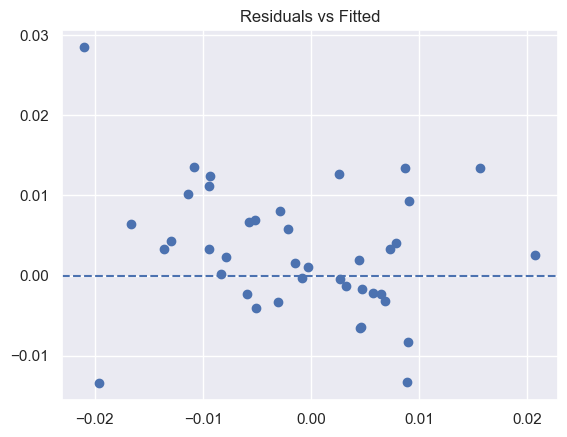

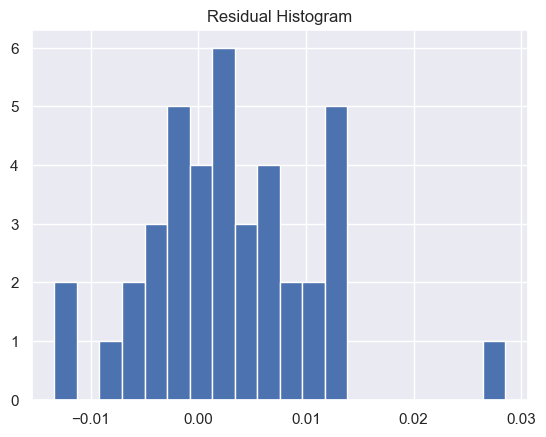

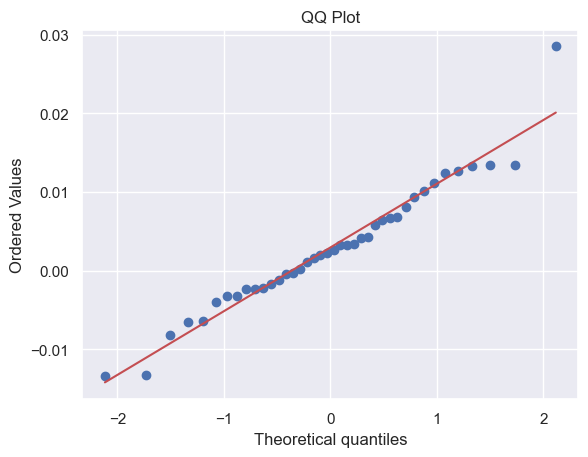

In [5]:
resid = y_test - y_pred
fitted = y_pred

# Residuals vs Fitted
plt.figure(); plt.scatter(fitted, resid); plt.axhline(0, ls='--'); plt.title('Residuals vs Fitted'); plt.show()

# Residual histogram
plt.figure(); plt.hist(resid, bins=20); plt.title('Residual Histogram'); plt.show()

# QQ plot
plt.figure(); st.probplot(resid, dist='norm', plot=plt); plt.title('QQ Plot'); plt.show()


In [6]:
df['momentum_sq'] = df['momentum']**2
X2 = df[['mkt_excess','size','value','momentum','momentum_sq']]

X2_train, X2_test = X2.iloc[:len(X_train)], X2.iloc[len(X_train):]
lr2 = LinearRegression().fit(X2_train, y_train)
y_pred2 = lr2.predict(X2_test)

r2_2 = r2_score(y_test, y_pred2)
rmse_2 = mean_squared_error(y_test, y_pred2) ** 0.5
print(f'With x^2   R²={r2_2:.4f}  RMSE={rmse_2:.6f}')


With x^2   R²=0.3681  RMSE=0.008467


### Interpretation

- **Linearity**: The residual plot shows curvature → baseline model does not capture all structure. Adding `momentum²` only slightly improves fit (R² from 0.368 → 0.368).
- **Homoscedasticity**: Residual spread increases with fitted values, showing heteroscedasticity. This is consistent with the synthetic generator (noise depends on market excess).
- **Normality**: Histogram and QQ plot show fat tails → residuals deviate from normal.
- **Independence**: Assumed IID in this synthetic setup; no clear serial correlation.

**Model comparison**:
- Baseline: R² ≈ 0.368, RMSE ≈ 0.00847  
- With `momentum²`: R² ≈ 0.368, RMSE ≈ 0.00847  

**Which to trust**: Although the quadratic term makes theoretical sense, here the improvement is minimal — noise dominates. In practice, I would still include it because it reflects the true data-generating process.

**Next step**: Try interaction terms (e.g., `size × value`), or use robust regression to account for heteroscedasticity. Larger datasets would also stabilize results.
